In [17]:
#source EPOTFenv/bin/activate (launching and exiting the virtual environment containing the required modules, stored in the working directory for VNA_Analysis)
#EPOTFenv/bin/python your_script.py - for running a script in the virtual environment
#source deactivate

#import all the libraries needed
from import_dep import *

# import my functions stored in the file 'functions' which can then be called with functions.function_name()
import functions

# Define the path to the output directory where data is saved
path_out =  ('/Users/horatiocox/Desktop/RUG Postdoc/Experiments/Electrical/VDP_JT029_SrRuO3')
# Define the path to the directories containing the experimental data
directory_1 = Path('/Users/horatiocox/Desktop/Electronic_properties_of_thin_films/Data/')


## Import Measurement Data 

In [18]:
data_np, data_df = functions.import_ppms_data(directory_1.joinpath('JT029_SrRuO3_171024_Combined_fullrange.txt'))
print('np shape:', data_np.shape)
print(data_df.head())

np shape: (850, 5, 6)
     Temp     Field  Source (A)  Source (V)  Sense (V)  index
0  4.9985 -0.199797    -0.00001     -0.0118  -0.000010      0
1  4.9985 -0.199797    -0.00001     -0.0118   0.000112      1
2  4.9985 -0.199797    -0.00001     -0.0118  -0.000673      2
3  4.9985 -0.199797    -0.00001     -0.0118  -0.000667      3
4  4.9985 -0.199797    -0.00001     -0.0118  -0.000541      4


In [19]:
df_np_first = pd.DataFrame(data_np[:,:,0], columns = data_df.columns[:-1])

## Extract and Check Temperature, Field, and Current values

In [20]:
# Extract the current, temperature and field values from the data as lists along with the number of values used for each
#ctf = [current_unique, temp_unique, field_unique, current_no, temp_no, field_no]
[ctf, tf_av] = functions.extract_ctf(data_np)

# Check you have the expected and correct Temperature, Field and Current values!
#ctf = [current_unique, temp_unique, field_unique, current_no, temp_no, field_no]
print(ctf[3],'Currents (uA):',ctf[0]/1e-6)  
print(ctf[4],'Temperatures (K):',ctf[1])
print(ctf[5],'Fields (kOe):',np.round(ctf[2]/1000,decimals=0))
print('Is this correct?')

5 Currents (uA): [-10.  -5.   0.   5.  10.]
17 Temperatures (K): [  5.  25.  45.  65.  85. 105. 125. 145. 165. 185. 205. 225. 245. 265.
 285. 305. 325.]
10 Fields (kOe): [ -0.  20.  40.  60.  80. -80. -60. -40. -20.  -0.]
Is this correct?


## Calculate Van der Pauw Resistivity 

In [21]:
film_thickness = 14e-9 # Film thickness in meters

[res_data, df_res_data, R_squared_res] = functions.vdp_resistivity(data_np, film_thickness, ctf, tf_av)

print(df_res_data.head())

     Temp         Field  rho_xx_A  rho_xx_B  rho_xx_average
0  4.9985     -0.199797  0.000004  0.000004        0.000004
1  4.9996  19999.792969  0.000004  0.000004        0.000004
2  5.0008  39999.574219  0.000004  0.000004        0.000004
3  4.9985  59999.566406  0.000004  0.000004        0.000004
4  5.0019  79999.773437  0.000004  0.000004        0.000004


## R-squared Analysis to Check Linearity of I-V data

average R-squared = 0.9999999173893903


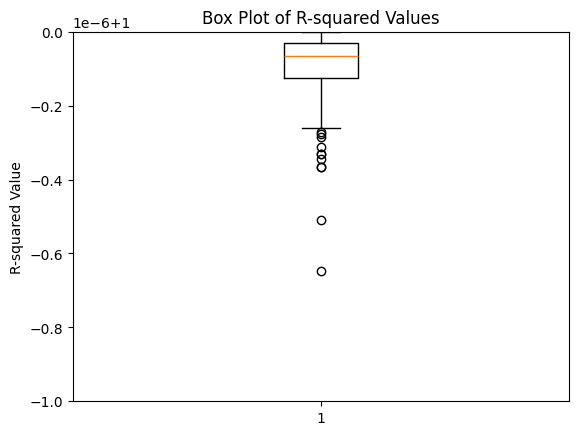

In [22]:
print('average R-squared =',sum(R_squared_res)/len(R_squared_res))

# Plot R-square values in a boxplot
# Note that the y axis is showing the deviation in 1e-6 from the perfect value of 1 so generally the values are very close to 1
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.boxplot(R_squared_res)
ax.set_title('Box Plot of R-squared Values')
ax.set_ylabel('R-squared Value')
ax.set_ylim(1-1e-6, 1)  # If needed, you can set x-axis limits too
plt.show()


### If you get a problem with regression, uncomment the below code to plot V vs I and check the linearity of the fit manually
# R_test = linregress(data_np[0:ctf[3]-1, 2, 2], data_np[0:ctf[3]-1, 4, 2])   
# plt.plot(data_np[0:ctf[3], 2, 2], data_np[0:ctf[3], 4, 2], 'o', label='original data')
# plt.plot(data_np[0:ctf[3], 2, 2], R_test.intercept + R_test.slope * data_np[0:ctf[3], 2, 2], 'r', label='fitted line')
# plt.legend()
# plt.show()


## Resistivity Configuration Compararison 
Comparing the resistivity in configuration A and B which are inverted versions of one another (e.g. source meter and sense meter swapped positions)
This is a good check for any systematic errors

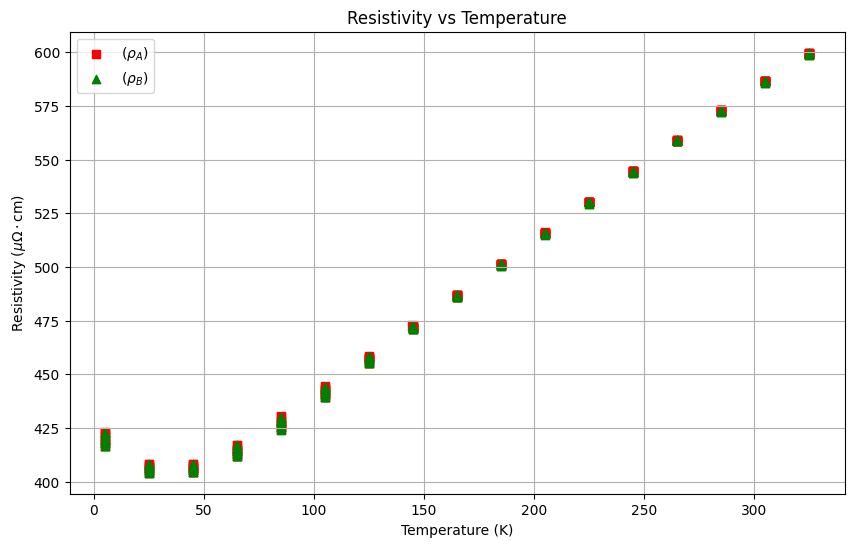

In [23]:
# Create a figure and axis
fig2 = plt.figure(figsize=(10, 6))
ax = fig2.add_subplot(111)  # Create a single subplot


# Plot R_sheet_A vs Temp
ax.scatter(res_data[:,0], res_data[:,2]* 1e8 , marker='s', color='r', label = r'($\rho_A$)')

# Plot R_sheet_B vs Temp
ax.scatter(res_data[:,0], res_data[:,3]* 1e8 , marker='^', color='g', label = r'($\rho_B$)')


# Set labels and title
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Resistivity ($\mu \Omega \cdot$cm)')
ax.set_title('Resistivity vs Temperature')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend()

# Show the plot
plt.show()

## Resistivity vs Temperature

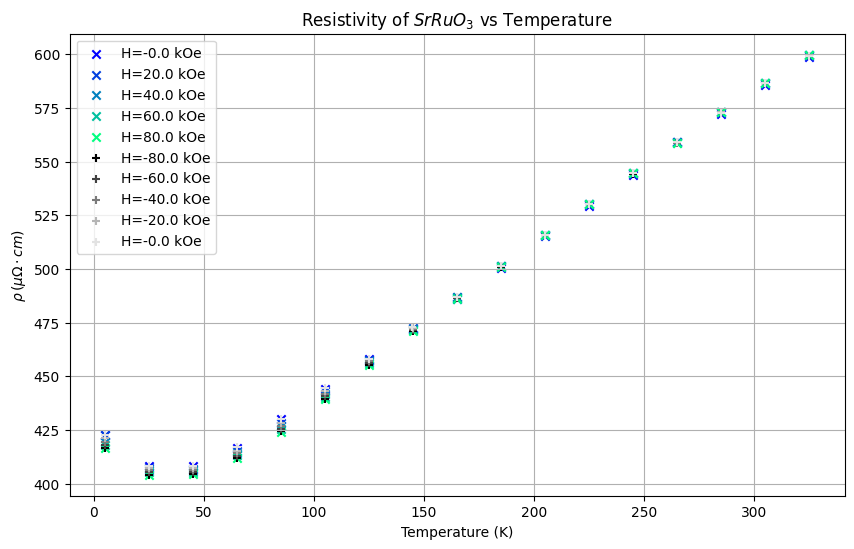

In [24]:
# Create a figure and axis
fig3 = plt.figure(figsize=(10, 6))
ax = fig3.add_subplot(111)  # Create a single subplot

#c_val = plt.cm.jet(np.linspace(0,1,num_field_points))
# Generating one set of colors for increasing positive field and one set for decreasing negative field
# higher field is brighter color in both cases
cmap1 = plt.get_cmap('winter')(np.linspace(0, 1, int(ctf[5] / 2)))
cmap2 = plt.get_cmap('Greys_r')(np.linspace(0, 0.8, int(ctf[5] / 2)))
c_val = np.vstack((cmap1, cmap2))

# Create separate marker arrays for positive and negative fields stiched together
markers = ['x'] * int(ctf[5] / 2) + ['+'] * int(ctf[5] / 2)


for k in range(ctf[5]):
    # Plot rho_film vs Temp
    ax.scatter(res_data[k::ctf[5],0], res_data[k::ctf[5],4] * 1e8, marker=markers[k], color=c_val[k], label = f'H={np.round(res_data[k,1]/1000,decimals=0)} kOe')

# Set labels and title
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'$\rho\,(\mu \Omega \cdot cm)$')
ax.set_title(r'Resistivity of $SrRuO_3$ vs Temperature')
# ax.set_xlim(0,100)
# ax.set_ylim(1425,1525)

# Add a grid
ax.grid(True)

# Add a legend
ax.legend()

# Show the plot
plt.show()

#fig3.savefig(Path(path_out).joinpath('resistivity_vs_temperature.png'))

## Magnetoresistance vs H
- Plotting the magnetoresistance vs the Applied field strength (H) for several temperatures

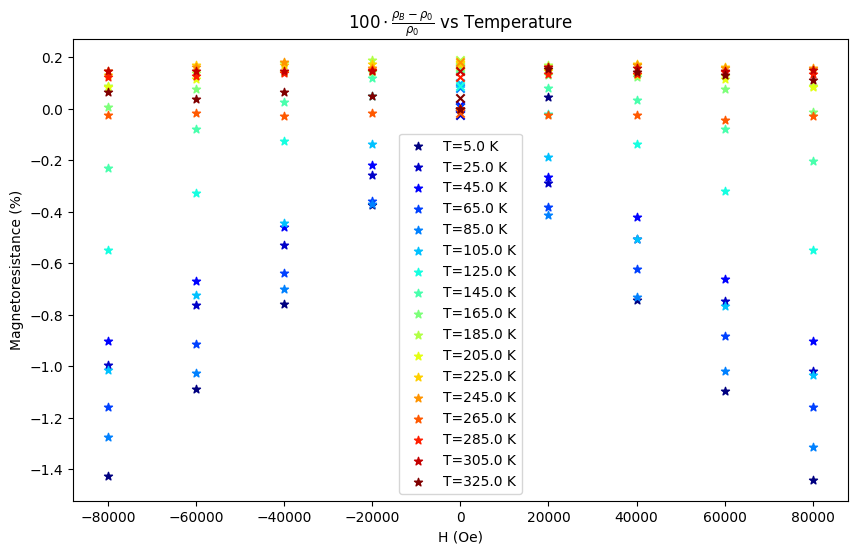

In [25]:

# Calculate the magnetoresistance at each temperature and field strength
# mag_res(temperature, field, index) where: index 0 = VDP config A, index 1 = VDP config B, index 2 = average of A and B
mag_res = functions.magnetoresistance(data_np, film_thickness, ctf, tf_av)

fig4 = plt.figure(figsize=(10, 6))
ax = fig4.add_subplot(111)  # Create a single subplot

# Create a color map for the tempearature points
c_val = plt.cm.jet(np.linspace(0,1,ctf[4]))
# Create a marker array for the temperature points
markers = markers = ['+','.','*', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', 'h', 'H', 'x', 'D', 'd', '|', '_']


for t_count, t in enumerate(ctf[1], start=0):  
    # Add a plot of magnetoresistance vs field strength for each loop of temperature (excluding last field point which is repeat of B=0)
    ax.scatter(ctf[2][:-1], mag_res[t_count,:-1,2], marker='*', color=c_val[t_count], label = f'T={t} K')
    #plot repeat point of B=0 with an x marker to show the difference between two B=0 points
    ax.scatter(ctf[2][-1], mag_res[t_count,-1,2], marker='x', color=c_val[t_count])
        

ax.set_xlabel('H (Oe)')
ax.set_ylabel(r'Magnetoresistance (%)')
ax.set_title(r'$100 \cdot \frac{\rho_{B} - \rho_{0}}{\rho_{0}}$ vs Temperature')
ax.legend()
plt.show()


## Magnetoresistance Vs T
- Now looking at how the Magnetoresitance at a set field strength varies over temperature
- Displaying this for VDP configuration A, VDP configuration B and the average of the two

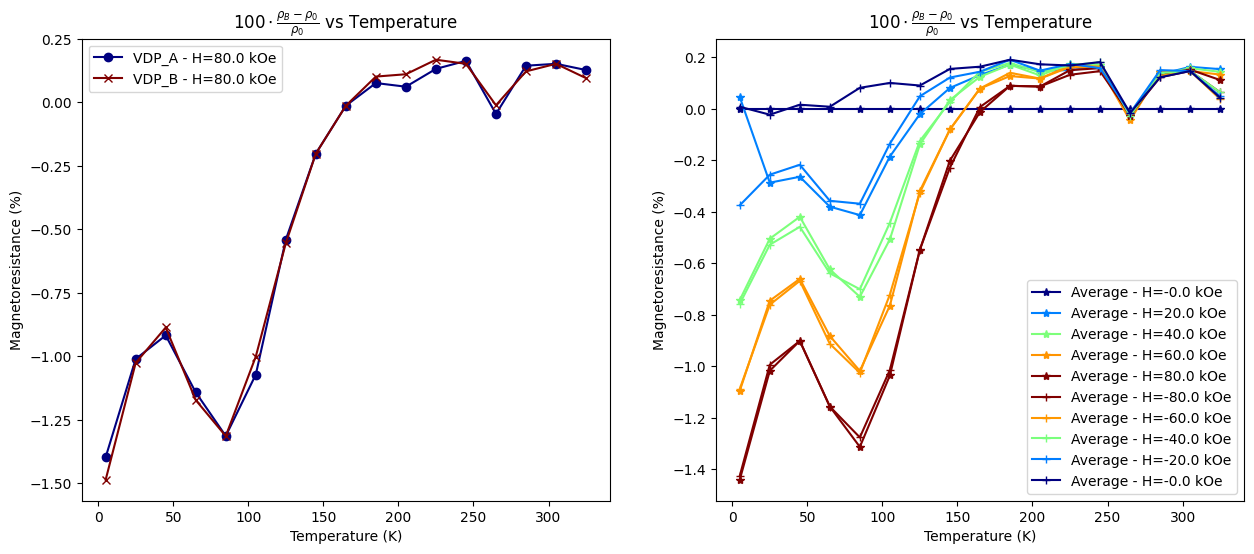

In [26]:
# Calculate the magnetoresistance at each temperature and field strength
# mag_res(temperature, field, index) where: index 0 = VDP config A, index 1 = VDP config B, index 2 = average of A and B
mag_res = functions.magnetoresistance(data_np, film_thickness, ctf, tf_av)

fig5 = plt.figure(figsize=(15, 6))
ax = fig5.add_subplot(121)  # Create two subplot
ax2 = fig5.add_subplot(122)  


# Generating one set of colors for increasing positive field and one set for decreasing negative field
# higher field is brighter color in both cases
cmap1 = plt.get_cmap('jet')(np.linspace(0, 1, int(ctf[5] / 2)))
cmap2 = plt.get_cmap('jet_r')(np.linspace(0, 1, int(ctf[5] / 2)))
c_val = np.vstack((cmap1, cmap2))

# Create separate marker arrays for positive and negative fields stiched together
markers = ['*'] * int(ctf[5] / 2) + ['+'] * int(ctf[5] / 2)

# Find the index of the maximum positive field strength
f_index = int(ctf[5]/2 - 1)

# Sub_plot 1: Comparing configurations A and B
ax.plot(ctf[1], mag_res[:,f_index,0], marker='o', color=c_val[0], label = f'VDP_A - H={np.round(ctf[2][f_index]/1000,0)} kOe')
ax.plot(ctf[1], mag_res[:,f_index,1], marker='x', color=c_val[int(len(c_val)/2)], label = f'VDP_B - H={np.round(ctf[2][f_index]/1000,0)} kOe')

ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Magnetoresistance (%)')
ax.set_title(r'$100 \cdot \frac{\rho_{B} - \rho_{0}}{\rho_{0}}$ vs Temperature')
ax.legend()

# Sub_plot 2: Comparing the average magnetoresistance vs T for various field strengths 

for H_count, H in enumerate(ctf[2], start=0):
    ax2.plot(ctf[1], mag_res[:,H_count,2], marker=markers[H_count], color=c_val[H_count], label = f'Average - H={np.round(ctf[2][H_count]/1000,0)} kOe')     

ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel(r'Magnetoresistance (%)')
ax2.set_title(r'$100 \cdot \frac{\rho_{B} - \rho_{0}}{\rho_{0}}$ vs Temperature')
ax2.legend()

plt.show()


## Arhenius Plot

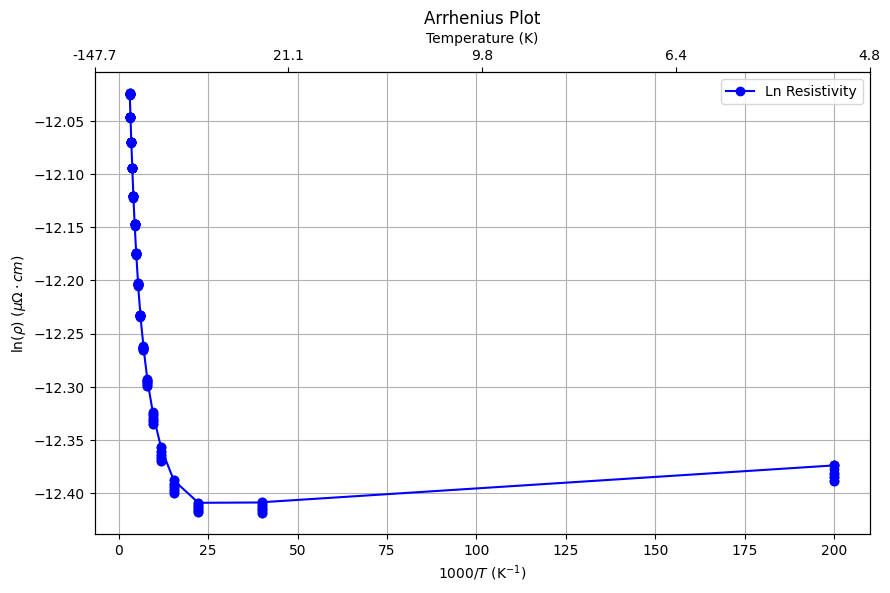

In [27]:
# Create a figure and axis
fig5 = plt.figure(figsize=(10, 6))
ax = fig5.add_subplot(111)  # Create a single subplot

# Plot rho_film vs 1000/Temp
ax.plot(1000 / df_res_data['Temp'], np.log(df_res_data['rho_xx_average']), marker='o', linestyle='-', color='b', label='Ln Resistivity')

# Set labels and title
ax.set_xlabel(r'$1000/T$ (K$^{-1}$)')
ax.set_ylabel(r'$\ln(\rho)$ ($\mu\Omega \cdot cm$)')
ax.set_title('Arrhenius Plot')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend()

# Create a secondary x-axis at the top
ax2 = ax.twiny()

# Set the limits of the secondary x-axis to match the primary x-axis
ax2.set_xlim(ax.get_xlim())

# Set the ticks and labels for the secondary x-axis
new_ticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], num=5)
ax2.set_xticks(new_ticks)
ax2.set_xticklabels([f'{1000/tick:.1f}' for tick in new_ticks])
ax2.set_xlabel('Temperature (K)')

# Show the plot
plt.show()

## Calculate the Hall Resistivity ($\rho_{xy}$)
- This is: $\frac{V_{measured-perpendicular}}{I_{source}}*t$


In [28]:
film_thickness = 14e-9 # Film thickness in meters

[hall_data, df_hall_data, hall_coefficient, df_hall_coefficient] = functions.vdp_hall(data_np, film_thickness, ctf, tf_av)
print(df_hall_data.head())

     Temp         Field      rho_xy_A  R_squared(I)_A      rho_xy_B  \
0  4.9985     -0.199797  6.913849e-09        0.999391  6.913849e-09   
1  4.9996  19999.792969 -2.208672e-08       -0.998659 -2.208672e-08   
2  5.0008  39999.574219 -2.854627e-08       -0.999987 -2.854627e-08   
3  4.9985  59999.566406 -2.905197e-08       -0.999988 -2.905197e-08   
4  5.0019  79999.773437 -2.886590e-08       -0.999978 -2.886590e-08   

   R_squared(I)_B  rho_xy_average  
0        0.999391    6.913849e-09  
1       -0.998659   -2.208672e-08  
2       -0.999987   -2.854627e-08  
3       -0.999988   -2.905197e-08  
4       -0.999978   -2.886590e-08  


## R-squared Analysis to Check Linearity of Resitivity I-V data

average R-squared_A = 0.9990706486644216
average R-squared_B = 0.9990706486644216


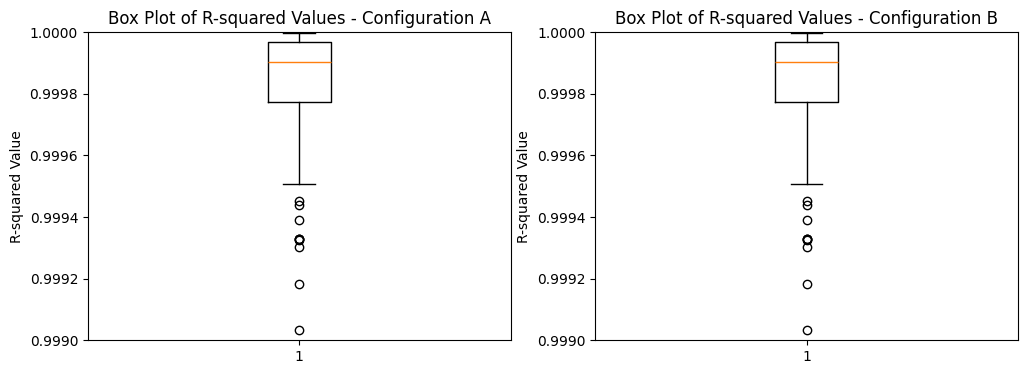

In [41]:
print('average R-squared_A =',np.mean(np.abs(hall_data[:,3])))
print('average R-squared_B =',np.mean(np.abs(hall_data[:,5])))

# Plot R-square values in a boxplot
# Note that the y axis is showing the deviation in 1e-6 from the perfect value of 1 so generally the values are very close to 1
fig6 = plt.figure(figsize=(12, 4))
ax = fig6.add_subplot(121)
ax.boxplot(np.abs(hall_data[:,3]))
ax.set_title('Box Plot of R-squared Values - Configuration A')
ax.set_ylabel('R-squared Value')
ax.set_ylim(1-1e-3, 1)  # If needed, you can set x-axis limits too

ax2 = fig6.add_subplot(122)
ax2.boxplot(np.abs(hall_data[:,5]))
ax2.set_title('Box Plot of R-squared Values - Configuration B')
ax2.set_ylabel('R-squared Value')
ax2.set_ylim(1-1e-3, 1)  # If needed, you can set x-axis limits too
plt.show()


### If you get a problem with regression, uncomment the below code to plot V vs I and check the linearity of the fit manually
# R_test = linregress(data_np[0:ctf[3]-1, 2, 2], data_np[0:ctf[3]-1, 4, 2])   
# plt.plot(data_np[0:ctf[3], 2, 2], data_np[0:ctf[3], 4, 2], 'o', label='original data')
# plt.plot(data_np[0:ctf[3], 2, 2], R_test.intercept + R_test.slope * data_np[0:ctf[3], 2, 2], 'r', label='fitted line')
# plt.legend()
# plt.show()


## Hall resisitivity vs Temperature

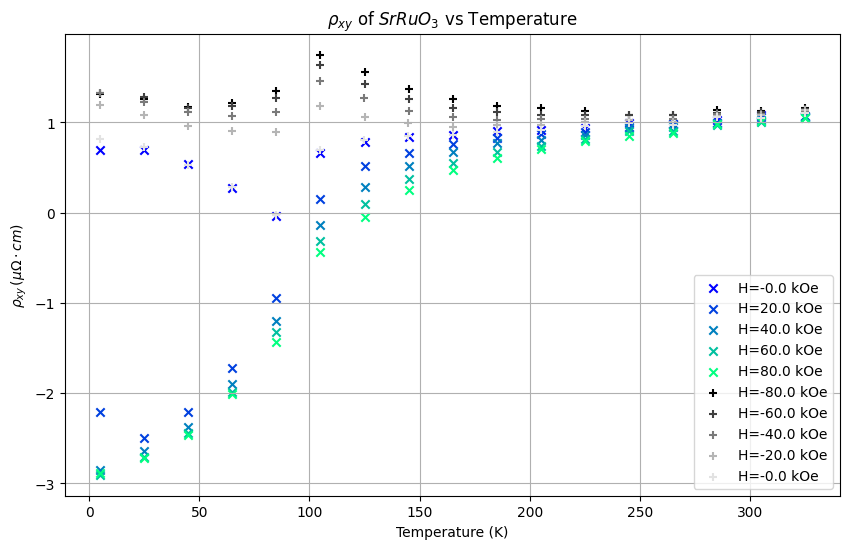

In [ ]:
# Create a figure and axis
fig7 = plt.figure(figsize=(10, 6))
ax = fig7.add_subplot(111)  # Create a single subplot

#c_val = plt.cm.jet(np.linspace(0,1,num_field_points))
# Generating one set of colors for increasing positive field and one set for decreasing negative field
# higher field is brighter color in both cases
cmap1 = plt.get_cmap('winter')(np.linspace(0, 1, int(ctf[5] / 2)))
cmap2 = plt.get_cmap('Greys_r')(np.linspace(0, 0.8, int(ctf[5] / 2)))
c_val = np.vstack((cmap1, cmap2))

# Create separate marker arrays for positive and negative fields stiched together
markers = ['x'] * int(ctf[5] / 2) + ['+'] * int(ctf[5] / 2)


for k in range(ctf[5]):
    # Plot rho_film vs Temp
    ax.scatter(hall_data[k::ctf[5],0], hall_data[k::ctf[5],6]*1e8 , marker=markers[k], color=c_val[k], label = f'H={np.round(hall_data[k,1]/1000,decimals=0)} kOe')

# Set labels and title
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
ax.set_title(r'$\rho_{xy}$ of $SrRuO_3$ vs Temperature')
# ax.set_xlim(0,100)
# ax.set_ylim(1425,1525)

# Add a grid
ax.grid(True)

# Add a legend
ax.legend()

# Show the plot
plt.show()

#fig3.savefig(Path(path_out).joinpath('resistivity_vs_temperature.png'))

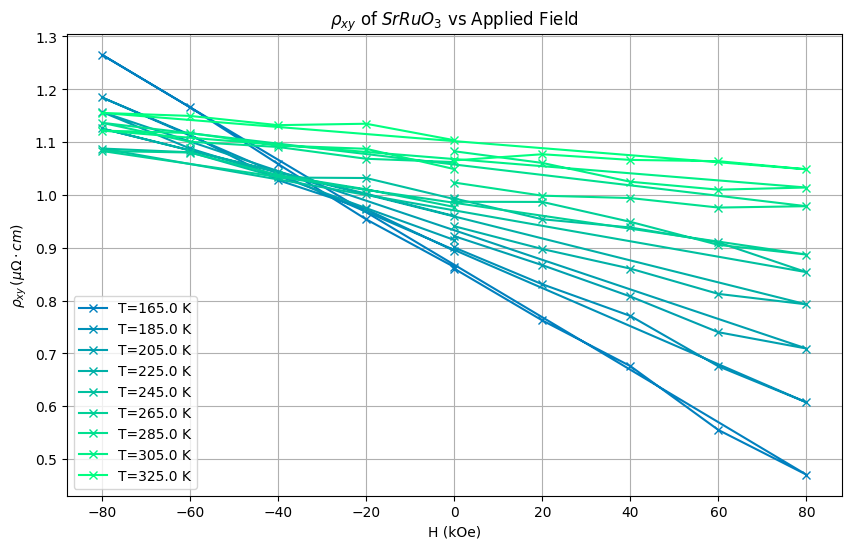

In [40]:
#ctf = [current_unique, temp_unique, field_unique, current_no, temp_no, field_no]

# Create a figure and axis
fig8 = plt.figure(figsize=(10, 6))
ax = fig8.add_subplot(111)  # Create a single subplot

#c_val = plt.cm.jet(np.linspace(0,1,num_field_points))
# Generating one set of colors for increasing positive field and one set for decreasing negative field
# higher field is brighter color in both cases
c_val = plt.get_cmap('winter')(np.linspace(0, 1, ctf[4]))


# Create separate marker arrays for positive and negative fields stiched together
markers = ['x'] * ctf[4]


for t_count, t in enumerate(ctf[1], start=0):
    if t > 150:
        index = t_count * ctf[5]
        # Plot rho_film vs Temp
        ax.plot(hall_data[index:index+ctf[5],1]/1000, hall_data[index:index+ctf[5],6]*1e8, marker=markers[t_count], color=c_val[t_count], label = f'T={np.round(t,decimals=0)} K')

# Set labels and title
ax.set_xlabel('H (kOe)')
ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
ax.set_title(r'$\rho_{xy}$ of $SrRuO_3$ vs Applied Field')
# ax.set_xlim(0,100)
# ax.set_ylim(1425,1525)

# Add a grid
ax.grid(True)

# Add a legend
ax.legend()

# Show the plot
plt.show()

#fig3.savefig(Path(path_out).joinpath('resistivity_vs_temperature.png'))

## Hall Coeff Vs T?

In [42]:
print(df_hall_coefficient.head())

      Temp         Field  Hallco_A  R_squared(H)_A  Hallco_B  R_squared(H)_B  \
0   4.9996 -3.440231e-13 -0.889592       -0.000017 -0.889592       -0.000008   
1  24.9951 -3.267670e-13 -0.880533       -0.000017 -0.880533       -0.000008   
2  45.0008 -2.959787e-13 -0.891883       -0.000017 -0.891883       -0.000008   
3  65.0158 -2.584372e-13 -0.921690       -0.000017 -0.921690       -0.000008   
4  84.9993 -2.113455e-13 -0.961492       -0.000017 -0.961492       -0.000008   

   Hallco_average  
0       -0.889592  
1       -0.880533  
2       -0.891883  
3       -0.921690  
4       -0.961492  


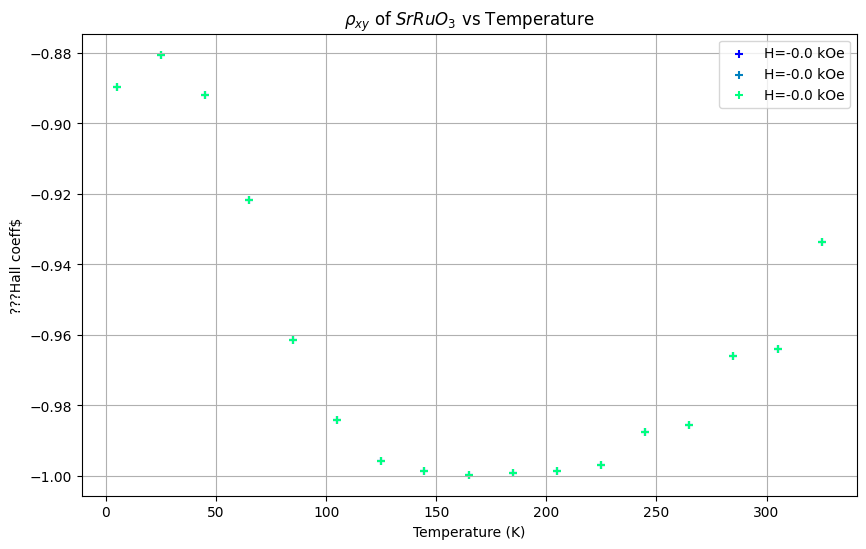

In [45]:
# Create a figure and axis
fig9 = plt.figure(figsize=(10, 6))
ax = fig9.add_subplot(111)  # Create a single subplot

#c_val = plt.cm.jet(np.linspace(0,1,num_field_points))
# Generating one set of colors for increasing positive field and one set for decreasing negative field
# higher field is brighter color in both cases
c_val = plt.get_cmap('winter')(np.linspace(0, 1, 3))


# Create separate marker arrays for positive and negative fields stiched together
markers = ['x'] * int(ctf[5] / 2) + ['+'] * int(ctf[5] / 2)


ax.scatter(hall_coefficient[:,0], hall_coefficient[:,2] , marker=markers[k], color=c_val[0], label = f'H={np.round(hall_data[k,1]/1000,decimals=0)} kOe')

ax.scatter(hall_coefficient[:,0], hall_coefficient[:,4] , marker=markers[k], color=c_val[1], label = f'H={np.round(hall_data[k,1]/1000,decimals=0)} kOe')

ax.scatter(hall_coefficient[:,0], hall_coefficient[:,6] , marker=markers[k], color=c_val[2], label = f'H={np.round(hall_data[k,1]/1000,decimals=0)} kOe')

# Set labels and title
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'???Hall coeff$')
ax.set_title(r'$\rho_{xy}$ of $SrRuO_3$ vs Temperature')
# ax.set_xlim(0,100)
# ax.set_ylim(1425,1525)

# Add a grid
ax.grid(True)

# Add a legend
ax.legend()

# Show the plot
plt.show()

#fig3.savefig(Path(path_out).joinpath('resistivity_vs_temperature.png'))

## $\rho_{xy}$ vs $\rho_{xx}$
- Can have problems where with both holes and electrons the carriers can cancel out the measured hall voltage
- Need to check this?

In [32]:
line_style_iterator = itertools.cycle(line_styles) #makes an iterator object that can be cyled through with next() to get the next line style
    color_maps = ['Greys_r','winter','autumn','Greens', 'Purples','Blues', 'Oranges',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn','Reds'] #list of sequential color maps to cycle through for each subset
    color_map_iterator = itertools.cycle(color_maps)
    color_obj = next(color_map_iterator)
    
colors = plt.get_cmap(color_obj)(np.linspace(0.1,0.9,num_colors))
            color_count = 0 #initiate color count to cycle through the colors for each device in the subset
            
            

IndentationError: unexpected indent (3570780470.py, line 2)